<a href="https://colab.research.google.com/github/BYT18/Q-Learning/blob/main/MountainCarFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#intall packages and environment 
!apt update
!apt install xvfb

!pip install 'gym[box2d]'
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install https://github.com/pyglet/pyglet/archive/pyglet-1.5-maintenance.zip
!apt-get install ffmpeg -y

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

In [ ]:
#import libraries 
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from datetime import datetime
import glob, os

env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1) #set seed so results are able to be reproduced


In [ ]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) 

In [ ]:
#create neural net
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100
        #self.hidden = 50
        #self.hidden2 = 50
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)

In [ ]:
# Hyperparameters
steps = 200 #how many moves are made before episode ends or goal is reached
state = env.reset()
epsilon = 0.3 #probability of making taking a random action instead of choosing the action with the highest Q-value
gamma = 0.99  #value of future rewards
loss_history = []
reward_history = []
episodes = 500  #how many iterations to train agent
max_position = -0.4
learning_rate = 0.001
successes = 0
position = []

maxpos=[]

eps = []

success_index = []

tau = 50  #how many episodes until target netowrk is updated

# Initialize policy / NN model
policy = Policy()

loss_fn = nn.MSELoss()
optimizer = optim.SGD(policy.parameters(), lr=learning_rate)  #stocastic gradient decent to minimize loss
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  #decays learning rate by gamma every 1 epoch

#train agent
for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset() #initiallize starting state
    
    #store the frames of succesful episodes 
    if (len(eps)>=10): #remove episode with most frames if succesful episodes more than 10 and if the max is more than current max to save memory space
      f=[]
      for i in range(len(eps)-1):
        f.append(len(eps[i]))
      maxIn = f.index(max(f))
      if (max(f)>len(eps[9])):
        eps.pop(maxIn)
      else:
        del eps[-1]

    frames = []

    for s in range(steps):
        # Uncomment to render environment
        #if episode % 100 == 0 and episode > 0:
        #    env.render()
        frames.append(env.render(mode = 'rgb_array'))
        
        
        # Get first action value function
        Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon: #if less random number between [0,1) is less than epsilon, choose random action (0,1, or 2)
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)  #choose best action based on Q-value
            action = action.item()
        
        # Step forward and receive next state and reward
        state_1, reward, done, _ = env.step(action)

        # Adjust reward based on car position
        reward = state_1[0] + 0.5

        # Keep track of max position
        if state_1[0] > max_position:
            max_position = state_1[0]
        
        # Adjust reward for task completion
        if state_1[0] >= 0.5:
            reward += 1
        
        # Find max Q for t+1 state
        Q1 = policy(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
        maxQ1, _ = torch.max(Q1, -1)
        
        #fixed Q-targets
        # Create target Q value for training the policy
        #for x in range(0,steps,50):
        if (episode % tau == 0):
          #print("new target")
          Q_target = Q.clone()
          Q_target = Variable(Q_target.data)
          Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy
        policy.zero_grad() 
        loss.backward() 
        optimizer.step()

        # Record history
        episode_loss += loss.item()
        episode_reward += reward
       
        # Keep track of max position
        if state_1[0] > max_position:
            max_position = state_1[0]
        
        if done:
            if state_1[0] >= 0.5:
                print('success')
                success_index.append(episode)
                eps.append(frames)

                # On successful epsisodes, adjust the following parameters

                # Adjust epsilon
                epsilon *= .95  #new epsidoes had a lower proability of performing a random action as opposed to an actio based on Q-value
              
                # Adjust learning rate
                scheduler.step() 

                # Record successful episode
                successes += 1
            
            elif state_1[0] < 0.5:
              print('fail')

            
            # Record history
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)
            weights = np.sum(np.abs(policy.l2.weight.data.numpy()))+np.sum(np.abs(policy.l1.weight.data.numpy())) #update weights of neural net
            position.append(state_1[0])

            break
        else:
            state = state_1 #continue to next step by adjusting state
            
print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

  0%|          | 1/500 [00:00<08:10,  1.02it/s]

fail


  0%|          | 2/500 [00:01<08:03,  1.03it/s]

fail


  1%|          | 3/500 [00:02<07:59,  1.04it/s]

fail


  1%|          | 4/500 [00:03<07:34,  1.09it/s]

fail


  1%|          | 5/500 [00:04<07:32,  1.09it/s]

fail


  1%|          | 6/500 [00:05<07:28,  1.10it/s]

fail


  1%|▏         | 7/500 [00:06<07:30,  1.10it/s]

fail


  2%|▏         | 8/500 [00:07<07:32,  1.09it/s]

fail


  2%|▏         | 9/500 [00:08<07:28,  1.09it/s]

fail


  2%|▏         | 10/500 [00:09<07:28,  1.09it/s]

fail


  2%|▏         | 11/500 [00:10<07:22,  1.10it/s]

fail


  2%|▏         | 12/500 [00:10<07:23,  1.10it/s]

fail


  3%|▎         | 13/500 [00:11<07:22,  1.10it/s]

fail


  3%|▎         | 14/500 [00:12<07:22,  1.10it/s]

fail


  3%|▎         | 15/500 [00:13<07:21,  1.10it/s]

fail


  3%|▎         | 16/500 [00:14<07:19,  1.10it/s]

fail


  3%|▎         | 17/500 [00:15<07:24,  1.09it/s]

fail


  4%|▎         | 18/500 [00:16<07:27,  1.08it/s]

fail


  4%|▍         | 19/500 [00:17<07:30,  1.07it/s]

fail


  4%|▍         | 20/500 [00:18<07:23,  1.08it/s]

fail


  4%|▍         | 21/500 [00:19<07:18,  1.09it/s]

fail


  4%|▍         | 22/500 [00:20<07:12,  1.10it/s]

fail


  5%|▍         | 23/500 [00:21<07:13,  1.10it/s]

fail


  5%|▍         | 24/500 [00:21<07:04,  1.12it/s]

fail


  5%|▌         | 25/500 [00:22<07:08,  1.11it/s]

fail


  5%|▌         | 26/500 [00:23<07:09,  1.10it/s]

fail


  5%|▌         | 27/500 [00:24<07:12,  1.09it/s]

fail


  6%|▌         | 28/500 [00:25<07:15,  1.08it/s]

fail


  6%|▌         | 29/500 [00:26<07:12,  1.09it/s]

fail


  6%|▌         | 30/500 [00:27<07:14,  1.08it/s]

fail


  6%|▌         | 31/500 [00:28<07:11,  1.09it/s]

fail


  6%|▋         | 32/500 [00:29<07:15,  1.07it/s]

fail


  7%|▋         | 33/500 [00:30<07:10,  1.08it/s]

fail


  7%|▋         | 34/500 [00:31<07:05,  1.09it/s]

fail


  7%|▋         | 35/500 [00:32<07:08,  1.09it/s]

fail


  7%|▋         | 36/500 [00:32<06:46,  1.14it/s]

fail


  7%|▋         | 37/500 [00:33<06:53,  1.12it/s]

fail


  8%|▊         | 38/500 [00:34<06:47,  1.13it/s]

fail


  8%|▊         | 39/500 [00:35<06:51,  1.12it/s]

fail


  8%|▊         | 40/500 [00:36<06:56,  1.10it/s]

fail


  8%|▊         | 41/500 [00:37<07:00,  1.09it/s]

fail


  8%|▊         | 42/500 [00:38<06:54,  1.11it/s]

fail


  9%|▊         | 43/500 [00:39<07:03,  1.08it/s]

fail


  9%|▉         | 44/500 [00:40<07:00,  1.08it/s]

fail


  9%|▉         | 45/500 [00:41<07:01,  1.08it/s]

fail


  9%|▉         | 46/500 [00:42<07:02,  1.08it/s]

fail


  9%|▉         | 47/500 [00:42<06:57,  1.09it/s]

fail


 10%|▉         | 48/500 [00:43<06:57,  1.08it/s]

fail


 10%|▉         | 49/500 [00:44<06:56,  1.08it/s]

fail


 10%|█         | 50/500 [00:45<06:58,  1.07it/s]

fail


 10%|█         | 51/500 [00:46<07:04,  1.06it/s]

fail


 10%|█         | 52/500 [00:47<06:54,  1.08it/s]

fail


 11%|█         | 53/500 [00:48<06:52,  1.08it/s]

fail


 11%|█         | 54/500 [00:49<06:52,  1.08it/s]

fail


 11%|█         | 55/500 [00:50<06:55,  1.07it/s]

fail


 11%|█         | 56/500 [00:51<06:56,  1.07it/s]

fail


 11%|█▏        | 57/500 [00:52<06:57,  1.06it/s]

fail


 12%|█▏        | 58/500 [00:53<06:48,  1.08it/s]

fail


 12%|█▏        | 59/500 [00:54<06:53,  1.07it/s]

fail


 12%|█▏        | 60/500 [00:55<06:51,  1.07it/s]

fail


 12%|█▏        | 61/500 [00:56<06:51,  1.07it/s]

fail


 12%|█▏        | 62/500 [00:56<06:53,  1.06it/s]

fail


 13%|█▎        | 63/500 [00:57<06:51,  1.06it/s]

fail


 13%|█▎        | 64/500 [00:58<06:51,  1.06it/s]

fail


 13%|█▎        | 65/500 [00:59<06:52,  1.05it/s]

fail


 13%|█▎        | 66/500 [01:00<06:46,  1.07it/s]

fail


 13%|█▎        | 67/500 [01:01<06:46,  1.07it/s]

fail


 14%|█▎        | 68/500 [01:02<06:40,  1.08it/s]

fail


 14%|█▍        | 69/500 [01:03<06:42,  1.07it/s]

fail


 14%|█▍        | 70/500 [01:04<06:36,  1.08it/s]

fail


 14%|█▍        | 71/500 [01:05<06:37,  1.08it/s]

fail


 14%|█▍        | 72/500 [01:06<06:35,  1.08it/s]

fail


 15%|█▍        | 73/500 [01:07<06:27,  1.10it/s]

fail


 15%|█▍        | 74/500 [01:08<06:29,  1.09it/s]

fail


 15%|█▌        | 75/500 [01:09<06:32,  1.08it/s]

fail


 15%|█▌        | 76/500 [01:09<06:35,  1.07it/s]

fail


 15%|█▌        | 77/500 [01:10<06:24,  1.10it/s]

fail


 16%|█▌        | 78/500 [01:11<06:40,  1.05it/s]

fail


 16%|█▌        | 79/500 [01:12<06:37,  1.06it/s]

fail


 16%|█▌        | 80/500 [01:13<06:33,  1.07it/s]

fail


 16%|█▌        | 81/500 [01:14<06:29,  1.07it/s]

fail


 16%|█▋        | 82/500 [01:15<06:27,  1.08it/s]

fail


 17%|█▋        | 83/500 [01:16<06:28,  1.07it/s]

fail


 17%|█▋        | 84/500 [01:17<06:30,  1.07it/s]

fail


 17%|█▋        | 85/500 [01:18<06:27,  1.07it/s]

fail


 17%|█▋        | 86/500 [01:19<06:29,  1.06it/s]

fail


 17%|█▋        | 87/500 [01:20<06:25,  1.07it/s]

fail


 18%|█▊        | 88/500 [01:21<06:28,  1.06it/s]

fail


 18%|█▊        | 89/500 [01:22<06:21,  1.08it/s]

fail


 18%|█▊        | 90/500 [01:23<06:24,  1.07it/s]

fail


 18%|█▊        | 91/500 [01:24<06:25,  1.06it/s]

fail


 18%|█▊        | 92/500 [01:24<06:25,  1.06it/s]

fail


 19%|█▊        | 93/500 [01:25<06:23,  1.06it/s]

fail


 19%|█▉        | 94/500 [01:26<06:13,  1.09it/s]

fail


 19%|█▉        | 95/500 [01:27<06:07,  1.10it/s]

fail


 19%|█▉        | 96/500 [01:28<06:14,  1.08it/s]

fail


 19%|█▉        | 97/500 [01:29<06:16,  1.07it/s]

fail


 20%|█▉        | 98/500 [01:30<06:14,  1.07it/s]

fail


 20%|█▉        | 99/500 [01:31<06:14,  1.07it/s]

fail


 20%|██        | 100/500 [01:32<06:11,  1.08it/s]

fail


 20%|██        | 101/500 [01:33<06:10,  1.08it/s]

fail


 20%|██        | 102/500 [01:34<05:51,  1.13it/s]

success


 21%|██        | 103/500 [01:34<05:50,  1.13it/s]

fail


 21%|██        | 104/500 [01:35<06:04,  1.09it/s]

fail


 21%|██        | 105/500 [01:36<06:05,  1.08it/s]

fail


 21%|██        | 106/500 [01:37<06:12,  1.06it/s]

fail


 21%|██▏       | 107/500 [01:38<06:09,  1.06it/s]

fail


 22%|██▏       | 108/500 [01:39<06:05,  1.07it/s]

fail


 22%|██▏       | 109/500 [01:40<05:58,  1.09it/s]

fail


 22%|██▏       | 110/500 [01:41<05:58,  1.09it/s]

fail


 22%|██▏       | 111/500 [01:42<05:58,  1.09it/s]

fail


 22%|██▏       | 112/500 [01:43<06:04,  1.07it/s]

fail


 23%|██▎       | 113/500 [01:44<06:01,  1.07it/s]

fail


 23%|██▎       | 114/500 [01:45<05:50,  1.10it/s]

fail


 23%|██▎       | 115/500 [01:46<05:51,  1.10it/s]

fail


 23%|██▎       | 116/500 [01:47<05:53,  1.09it/s]

fail


 23%|██▎       | 117/500 [01:48<05:55,  1.08it/s]

fail


 24%|██▎       | 118/500 [01:48<05:55,  1.07it/s]

fail


 24%|██▍       | 119/500 [01:49<05:54,  1.08it/s]

fail


 24%|██▍       | 120/500 [01:50<05:54,  1.07it/s]

fail


 24%|██▍       | 121/500 [01:51<05:50,  1.08it/s]

fail


 24%|██▍       | 122/500 [01:52<05:49,  1.08it/s]

fail


 25%|██▍       | 123/500 [01:53<05:52,  1.07it/s]

fail


 25%|██▍       | 124/500 [01:54<05:51,  1.07it/s]

fail


 25%|██▌       | 125/500 [01:55<05:50,  1.07it/s]

fail


 25%|██▌       | 126/500 [01:56<05:45,  1.08it/s]

fail


 25%|██▌       | 127/500 [01:57<05:49,  1.07it/s]

fail


 26%|██▌       | 128/500 [01:58<05:52,  1.05it/s]

fail


 26%|██▌       | 129/500 [01:59<05:53,  1.05it/s]

fail


 26%|██▌       | 130/500 [02:00<05:50,  1.06it/s]

fail


 26%|██▌       | 131/500 [02:01<05:51,  1.05it/s]

fail


 26%|██▋       | 132/500 [02:02<05:50,  1.05it/s]

fail


 27%|██▋       | 133/500 [02:03<05:43,  1.07it/s]

fail


 27%|██▋       | 134/500 [02:03<05:42,  1.07it/s]

fail


 27%|██▋       | 135/500 [02:04<05:41,  1.07it/s]

fail


 27%|██▋       | 136/500 [02:05<05:42,  1.06it/s]

fail


 27%|██▋       | 137/500 [02:06<05:38,  1.07it/s]

fail


 28%|██▊       | 138/500 [02:07<05:34,  1.08it/s]

fail


 28%|██▊       | 139/500 [02:08<05:33,  1.08it/s]

fail


 28%|██▊       | 140/500 [02:09<05:38,  1.06it/s]

fail


 28%|██▊       | 141/500 [02:10<05:32,  1.08it/s]

fail


 28%|██▊       | 142/500 [02:11<05:30,  1.08it/s]

fail


 29%|██▊       | 143/500 [02:12<05:28,  1.09it/s]

fail


 29%|██▉       | 144/500 [02:13<05:25,  1.09it/s]

fail


 29%|██▉       | 145/500 [02:14<05:28,  1.08it/s]

fail


 29%|██▉       | 146/500 [02:15<05:28,  1.08it/s]

fail


 29%|██▉       | 147/500 [02:16<05:27,  1.08it/s]

fail


 30%|██▉       | 148/500 [02:16<05:27,  1.07it/s]

fail


 30%|██▉       | 149/500 [02:17<05:31,  1.06it/s]

fail


 30%|███       | 150/500 [02:18<05:32,  1.05it/s]

fail


 30%|███       | 151/500 [02:19<05:27,  1.07it/s]

fail


 30%|███       | 152/500 [02:20<05:26,  1.07it/s]

fail


 31%|███       | 153/500 [02:21<05:27,  1.06it/s]

fail


 31%|███       | 154/500 [02:22<05:24,  1.07it/s]

fail


 31%|███       | 155/500 [02:23<05:23,  1.07it/s]

fail


 31%|███       | 156/500 [02:24<05:20,  1.07it/s]

fail


 31%|███▏      | 157/500 [02:25<05:17,  1.08it/s]

fail


 32%|███▏      | 158/500 [02:26<05:20,  1.07it/s]

fail


 32%|███▏      | 159/500 [02:27<05:17,  1.08it/s]

fail


 32%|███▏      | 160/500 [02:28<05:15,  1.08it/s]

fail


 32%|███▏      | 161/500 [02:29<05:12,  1.09it/s]

fail


 32%|███▏      | 162/500 [02:30<05:10,  1.09it/s]

fail


 33%|███▎      | 163/500 [02:30<05:09,  1.09it/s]

fail


 33%|███▎      | 164/500 [02:31<05:07,  1.09it/s]

fail


 33%|███▎      | 165/500 [02:32<05:05,  1.10it/s]

fail


 33%|███▎      | 166/500 [02:33<05:05,  1.10it/s]

fail


 33%|███▎      | 167/500 [02:34<05:08,  1.08it/s]

fail


 34%|███▎      | 168/500 [02:35<05:09,  1.07it/s]

fail


 34%|███▍      | 169/500 [02:36<05:05,  1.08it/s]

fail


 34%|███▍      | 170/500 [02:37<05:03,  1.09it/s]

fail


 34%|███▍      | 171/500 [02:38<05:05,  1.08it/s]

fail


 34%|███▍      | 172/500 [02:39<05:16,  1.04it/s]

fail


 35%|███▍      | 173/500 [02:40<05:15,  1.04it/s]

fail


 35%|███▍      | 174/500 [02:41<05:10,  1.05it/s]

fail


 35%|███▌      | 175/500 [02:42<05:04,  1.07it/s]

fail


 35%|███▌      | 176/500 [02:43<05:02,  1.07it/s]

fail


 35%|███▌      | 177/500 [02:44<05:04,  1.06it/s]

fail


 36%|███▌      | 178/500 [02:45<05:05,  1.05it/s]

fail


 36%|███▌      | 179/500 [02:45<05:06,  1.05it/s]

fail


 36%|███▌      | 180/500 [02:47<05:12,  1.02it/s]

fail


 36%|███▌      | 181/500 [02:47<05:10,  1.03it/s]

fail


 36%|███▋      | 182/500 [02:48<05:11,  1.02it/s]

fail


 37%|███▋      | 183/500 [02:49<05:07,  1.03it/s]

fail


 37%|███▋      | 184/500 [02:50<05:14,  1.00it/s]

fail


 37%|███▋      | 185/500 [02:51<05:07,  1.02it/s]

fail


 37%|███▋      | 186/500 [02:52<05:03,  1.04it/s]

fail


 37%|███▋      | 187/500 [02:53<04:59,  1.04it/s]

fail


 38%|███▊      | 188/500 [02:54<04:55,  1.06it/s]

fail


 38%|███▊      | 189/500 [02:55<04:49,  1.08it/s]

fail


 38%|███▊      | 190/500 [02:56<04:46,  1.08it/s]

fail


 38%|███▊      | 191/500 [02:57<04:48,  1.07it/s]

fail


 38%|███▊      | 192/500 [02:58<04:45,  1.08it/s]

fail


 39%|███▊      | 193/500 [02:59<04:42,  1.09it/s]

fail


 39%|███▉      | 194/500 [03:00<04:41,  1.09it/s]

fail


 39%|███▉      | 195/500 [03:01<04:41,  1.08it/s]

fail


 39%|███▉      | 196/500 [03:02<04:39,  1.09it/s]

fail


 39%|███▉      | 197/500 [03:02<04:38,  1.09it/s]

fail


 40%|███▉      | 198/500 [03:03<04:38,  1.08it/s]

fail


 40%|███▉      | 199/500 [03:04<04:39,  1.08it/s]

fail


 40%|████      | 200/500 [03:05<04:25,  1.13it/s]

fail


 40%|████      | 201/500 [03:06<04:27,  1.12it/s]

fail


 40%|████      | 202/500 [03:07<04:25,  1.12it/s]

fail


 41%|████      | 203/500 [03:08<04:23,  1.13it/s]

fail


 41%|████      | 204/500 [03:09<04:23,  1.12it/s]

fail


 41%|████      | 205/500 [03:10<04:25,  1.11it/s]

fail


 41%|████      | 206/500 [03:10<04:23,  1.11it/s]

fail


 41%|████▏     | 207/500 [03:11<04:23,  1.11it/s]

fail


 42%|████▏     | 208/500 [03:12<04:19,  1.13it/s]

fail


 42%|████▏     | 209/500 [03:13<04:18,  1.13it/s]

fail


 42%|████▏     | 210/500 [03:14<04:18,  1.12it/s]

fail


 42%|████▏     | 211/500 [03:15<04:20,  1.11it/s]

fail


 42%|████▏     | 212/500 [03:16<04:20,  1.11it/s]

fail


 43%|████▎     | 213/500 [03:17<04:14,  1.13it/s]

fail


 43%|████▎     | 214/500 [03:18<04:12,  1.13it/s]

fail


 43%|████▎     | 215/500 [03:18<04:08,  1.15it/s]

fail


 43%|████▎     | 216/500 [03:19<04:10,  1.13it/s]

fail


 43%|████▎     | 217/500 [03:20<04:13,  1.11it/s]

fail


 44%|████▎     | 218/500 [03:21<04:14,  1.11it/s]

fail


 44%|████▍     | 219/500 [03:22<04:16,  1.10it/s]

fail


 44%|████▍     | 220/500 [03:23<04:14,  1.10it/s]

fail


 44%|████▍     | 221/500 [03:24<04:13,  1.10it/s]

fail


 44%|████▍     | 222/500 [03:25<04:10,  1.11it/s]

fail


 45%|████▍     | 223/500 [03:26<04:06,  1.12it/s]

fail


 45%|████▍     | 224/500 [03:27<04:05,  1.13it/s]

fail


 45%|████▌     | 225/500 [03:27<04:02,  1.14it/s]

fail


 45%|████▌     | 226/500 [03:28<04:01,  1.14it/s]

fail


 45%|████▌     | 227/500 [03:29<04:00,  1.14it/s]

fail


 46%|████▌     | 228/500 [03:30<04:02,  1.12it/s]

fail


 46%|████▌     | 229/500 [03:31<04:04,  1.11it/s]

fail


 46%|████▌     | 230/500 [03:32<04:01,  1.12it/s]

fail


 46%|████▌     | 231/500 [03:33<04:00,  1.12it/s]

fail


 46%|████▋     | 232/500 [03:34<03:58,  1.13it/s]

fail


 47%|████▋     | 233/500 [03:35<03:58,  1.12it/s]

fail


 47%|████▋     | 234/500 [03:35<03:55,  1.13it/s]

fail


 47%|████▋     | 235/500 [03:36<03:57,  1.12it/s]

fail


 47%|████▋     | 236/500 [03:37<03:57,  1.11it/s]

fail


 47%|████▋     | 237/500 [03:38<03:53,  1.12it/s]

fail


 48%|████▊     | 238/500 [03:39<03:53,  1.12it/s]

fail


 48%|████▊     | 239/500 [03:40<03:54,  1.11it/s]

fail


 48%|████▊     | 240/500 [03:41<03:54,  1.11it/s]

fail


 48%|████▊     | 241/500 [03:42<03:55,  1.10it/s]

fail


 48%|████▊     | 242/500 [03:43<03:50,  1.12it/s]

fail


 49%|████▊     | 243/500 [03:44<03:53,  1.10it/s]

fail


 49%|████▉     | 244/500 [03:45<03:53,  1.10it/s]

fail


 49%|████▉     | 245/500 [03:45<03:52,  1.10it/s]

fail


 49%|████▉     | 246/500 [03:46<03:53,  1.09it/s]

fail


 49%|████▉     | 247/500 [03:47<03:52,  1.09it/s]

fail


 50%|████▉     | 248/500 [03:48<03:47,  1.11it/s]

fail


 50%|████▉     | 249/500 [03:49<03:45,  1.11it/s]

fail


 50%|█████     | 250/500 [03:50<03:48,  1.10it/s]

fail


 50%|█████     | 251/500 [03:51<03:50,  1.08it/s]

fail


 50%|█████     | 252/500 [03:52<03:46,  1.09it/s]

fail


 51%|█████     | 253/500 [03:53<03:47,  1.08it/s]

fail


 51%|█████     | 254/500 [03:54<03:46,  1.09it/s]

fail


 51%|█████     | 255/500 [03:55<03:44,  1.09it/s]

fail


 51%|█████     | 256/500 [03:55<03:39,  1.11it/s]

fail


 51%|█████▏    | 257/500 [03:56<03:35,  1.13it/s]

fail


 52%|█████▏    | 258/500 [03:57<03:32,  1.14it/s]

fail


 52%|█████▏    | 259/500 [03:58<03:34,  1.12it/s]

fail


 52%|█████▏    | 260/500 [03:59<03:34,  1.12it/s]

fail


 52%|█████▏    | 261/500 [04:00<03:35,  1.11it/s]

fail


 52%|█████▏    | 262/500 [04:01<03:31,  1.12it/s]

fail


 53%|█████▎    | 263/500 [04:02<03:32,  1.12it/s]

fail


 53%|█████▎    | 264/500 [04:03<03:33,  1.11it/s]

fail


 53%|█████▎    | 265/500 [04:04<03:31,  1.11it/s]

fail


 53%|█████▎    | 266/500 [04:04<03:32,  1.10it/s]

fail


 53%|█████▎    | 267/500 [04:05<03:27,  1.12it/s]

fail


 54%|█████▎    | 268/500 [04:06<03:28,  1.11it/s]

fail


 54%|█████▍    | 269/500 [04:07<03:28,  1.11it/s]

fail


 54%|█████▍    | 270/500 [04:08<03:26,  1.12it/s]

fail


 54%|█████▍    | 271/500 [04:09<03:25,  1.11it/s]

fail


 54%|█████▍    | 272/500 [04:10<03:27,  1.10it/s]

fail


 55%|█████▍    | 273/500 [04:11<03:27,  1.10it/s]

fail


 55%|█████▍    | 274/500 [04:12<03:28,  1.08it/s]

fail


 55%|█████▌    | 275/500 [04:13<03:26,  1.09it/s]

fail


 55%|█████▌    | 276/500 [04:14<03:25,  1.09it/s]

fail


 55%|█████▌    | 277/500 [04:14<03:21,  1.10it/s]

fail


 56%|█████▌    | 278/500 [04:15<03:24,  1.09it/s]

fail


 56%|█████▌    | 279/500 [04:16<03:25,  1.08it/s]

fail


 56%|█████▌    | 280/500 [04:17<03:21,  1.09it/s]

fail


 56%|█████▌    | 281/500 [04:18<03:20,  1.09it/s]

fail


 56%|█████▋    | 282/500 [04:19<03:22,  1.08it/s]

fail


 57%|█████▋    | 283/500 [04:20<03:22,  1.07it/s]

fail


 57%|█████▋    | 284/500 [04:21<03:22,  1.07it/s]

fail


 57%|█████▋    | 285/500 [04:22<03:22,  1.06it/s]

fail


 57%|█████▋    | 286/500 [04:23<03:21,  1.06it/s]

fail


 57%|█████▋    | 287/500 [04:24<03:22,  1.05it/s]

fail


 58%|█████▊    | 288/500 [04:25<03:18,  1.07it/s]

fail


 58%|█████▊    | 289/500 [04:26<03:15,  1.08it/s]

fail


 58%|█████▊    | 290/500 [04:27<03:13,  1.09it/s]

fail


 58%|█████▊    | 291/500 [04:27<03:09,  1.10it/s]

fail


 58%|█████▊    | 292/500 [04:28<03:07,  1.11it/s]

fail


 59%|█████▊    | 293/500 [04:29<03:07,  1.10it/s]

fail


 59%|█████▉    | 294/500 [04:30<03:02,  1.13it/s]

fail


 59%|█████▉    | 295/500 [04:31<03:04,  1.11it/s]

fail


 59%|█████▉    | 296/500 [04:32<03:04,  1.11it/s]

fail


 59%|█████▉    | 297/500 [04:33<03:04,  1.10it/s]

fail


 60%|█████▉    | 298/500 [04:34<03:05,  1.09it/s]

fail


 60%|█████▉    | 299/500 [04:35<03:03,  1.10it/s]

fail


 60%|██████    | 300/500 [04:36<03:03,  1.09it/s]

fail


 60%|██████    | 301/500 [04:37<03:02,  1.09it/s]

fail


 60%|██████    | 302/500 [04:37<03:03,  1.08it/s]

fail


 61%|██████    | 303/500 [04:38<03:05,  1.06it/s]

fail


 61%|██████    | 304/500 [04:39<03:03,  1.07it/s]

fail


 61%|██████    | 305/500 [04:40<03:01,  1.08it/s]

fail


 61%|██████    | 306/500 [04:41<02:55,  1.11it/s]

fail


 61%|██████▏   | 307/500 [04:42<02:55,  1.10it/s]

fail


 62%|██████▏   | 308/500 [04:43<02:53,  1.11it/s]

fail


 62%|██████▏   | 309/500 [04:44<02:56,  1.08it/s]

fail


 62%|██████▏   | 310/500 [04:45<02:55,  1.08it/s]

fail


 62%|██████▏   | 311/500 [04:46<02:55,  1.08it/s]

fail


 62%|██████▏   | 312/500 [04:47<02:55,  1.07it/s]

fail


 63%|██████▎   | 313/500 [04:48<02:53,  1.08it/s]

fail


 63%|██████▎   | 314/500 [04:49<02:54,  1.07it/s]

fail


 63%|██████▎   | 315/500 [04:49<02:51,  1.08it/s]

fail


 63%|██████▎   | 316/500 [04:50<02:51,  1.07it/s]

fail


 63%|██████▎   | 317/500 [04:51<02:48,  1.09it/s]

fail


 64%|██████▎   | 318/500 [04:52<02:48,  1.08it/s]

fail


 64%|██████▍   | 319/500 [04:53<02:48,  1.08it/s]

fail


 64%|██████▍   | 320/500 [04:54<02:48,  1.07it/s]

fail


 64%|██████▍   | 321/500 [04:55<02:44,  1.09it/s]

fail


 64%|██████▍   | 322/500 [04:56<02:43,  1.09it/s]

fail


 65%|██████▍   | 323/500 [04:57<02:43,  1.08it/s]

fail


 65%|██████▍   | 324/500 [04:58<02:43,  1.08it/s]

fail


 65%|██████▌   | 325/500 [04:59<02:41,  1.08it/s]

fail


 65%|██████▌   | 326/500 [05:00<02:40,  1.08it/s]

fail


 65%|██████▌   | 327/500 [05:01<02:39,  1.08it/s]

fail


 66%|██████▌   | 328/500 [05:02<02:39,  1.08it/s]

fail


 66%|██████▌   | 329/500 [05:02<02:37,  1.09it/s]

fail


 66%|██████▌   | 330/500 [05:03<02:36,  1.08it/s]

fail


 66%|██████▌   | 331/500 [05:04<02:35,  1.09it/s]

fail


 66%|██████▋   | 332/500 [05:05<02:35,  1.08it/s]

fail


 67%|██████▋   | 333/500 [05:06<02:31,  1.10it/s]

fail


 67%|██████▋   | 334/500 [05:07<02:30,  1.10it/s]

fail


 67%|██████▋   | 335/500 [05:08<02:31,  1.09it/s]

fail


 67%|██████▋   | 336/500 [05:09<02:30,  1.09it/s]

fail


 67%|██████▋   | 337/500 [05:10<02:25,  1.12it/s]

fail


 68%|██████▊   | 338/500 [05:11<02:26,  1.10it/s]

fail


 68%|██████▊   | 339/500 [05:11<02:22,  1.13it/s]

fail


 68%|██████▊   | 340/500 [05:12<02:22,  1.12it/s]

fail


 68%|██████▊   | 341/500 [05:13<02:23,  1.11it/s]

fail


 68%|██████▊   | 342/500 [05:14<02:23,  1.10it/s]

fail


 69%|██████▊   | 343/500 [05:15<02:22,  1.10it/s]

fail


 69%|██████▉   | 344/500 [05:16<02:21,  1.10it/s]

fail


 69%|██████▉   | 345/500 [05:17<02:22,  1.09it/s]

fail


 69%|██████▉   | 346/500 [05:18<02:20,  1.10it/s]

fail


 69%|██████▉   | 347/500 [05:19<02:20,  1.09it/s]

fail


 70%|██████▉   | 348/500 [05:20<02:20,  1.08it/s]

fail


 70%|██████▉   | 349/500 [05:21<02:18,  1.09it/s]

fail


 70%|███████   | 350/500 [05:22<02:17,  1.09it/s]

fail


 70%|███████   | 351/500 [05:22<02:17,  1.09it/s]

fail


 70%|███████   | 352/500 [05:23<02:16,  1.08it/s]

fail


 71%|███████   | 353/500 [05:24<02:16,  1.08it/s]

fail


 71%|███████   | 354/500 [05:25<02:14,  1.08it/s]

fail


 71%|███████   | 355/500 [05:26<02:12,  1.09it/s]

fail


 71%|███████   | 356/500 [05:27<02:12,  1.09it/s]

fail


 71%|███████▏  | 357/500 [05:28<02:10,  1.09it/s]

fail


 72%|███████▏  | 358/500 [05:29<02:10,  1.09it/s]

fail


 72%|███████▏  | 359/500 [05:30<02:08,  1.10it/s]

fail


 72%|███████▏  | 360/500 [05:31<02:08,  1.09it/s]

fail


 72%|███████▏  | 361/500 [05:32<02:07,  1.09it/s]

fail


 72%|███████▏  | 362/500 [05:33<02:05,  1.10it/s]

fail


 73%|███████▎  | 363/500 [05:33<02:04,  1.10it/s]

fail


 73%|███████▎  | 364/500 [05:34<02:03,  1.10it/s]

fail


 73%|███████▎  | 365/500 [05:35<02:03,  1.09it/s]

fail


 73%|███████▎  | 366/500 [05:36<02:03,  1.09it/s]

fail


 73%|███████▎  | 367/500 [05:37<02:02,  1.09it/s]

fail


 74%|███████▎  | 368/500 [05:38<02:01,  1.09it/s]

fail


 74%|███████▍  | 369/500 [05:39<02:01,  1.08it/s]

fail


 74%|███████▍  | 370/500 [05:40<02:00,  1.08it/s]

fail


 74%|███████▍  | 371/500 [05:41<01:58,  1.09it/s]

fail


 74%|███████▍  | 372/500 [05:42<01:56,  1.10it/s]

fail


 75%|███████▍  | 373/500 [05:43<01:55,  1.10it/s]

fail


 75%|███████▍  | 374/500 [05:43<01:53,  1.11it/s]

fail


 75%|███████▌  | 375/500 [05:44<01:53,  1.11it/s]

fail


 75%|███████▌  | 376/500 [05:45<01:52,  1.10it/s]

fail


 75%|███████▌  | 377/500 [05:46<01:51,  1.11it/s]

fail


 76%|███████▌  | 378/500 [05:47<01:52,  1.08it/s]

fail


 76%|███████▌  | 379/500 [05:48<01:52,  1.07it/s]

fail


 76%|███████▌  | 380/500 [05:49<01:51,  1.08it/s]

fail


 76%|███████▌  | 381/500 [05:50<01:51,  1.07it/s]

fail


 76%|███████▋  | 382/500 [05:51<01:50,  1.07it/s]

fail


 77%|███████▋  | 383/500 [05:52<01:49,  1.06it/s]

fail


 77%|███████▋  | 384/500 [05:53<01:48,  1.06it/s]

fail


 77%|███████▋  | 385/500 [05:54<01:49,  1.05it/s]

fail


 77%|███████▋  | 386/500 [05:55<01:47,  1.06it/s]

fail


 77%|███████▋  | 387/500 [05:56<01:46,  1.06it/s]

fail


 78%|███████▊  | 388/500 [05:57<01:43,  1.08it/s]

fail


 78%|███████▊  | 389/500 [05:58<01:43,  1.07it/s]

fail


 78%|███████▊  | 390/500 [05:58<01:42,  1.07it/s]

fail


 78%|███████▊  | 391/500 [05:59<01:41,  1.07it/s]

fail


 78%|███████▊  | 392/500 [06:00<01:40,  1.07it/s]

fail


 79%|███████▊  | 393/500 [06:01<01:39,  1.07it/s]

fail


 79%|███████▉  | 394/500 [06:02<01:38,  1.08it/s]

fail


 79%|███████▉  | 395/500 [06:03<01:36,  1.08it/s]

fail


 79%|███████▉  | 396/500 [06:04<01:36,  1.08it/s]

fail


 79%|███████▉  | 397/500 [06:05<01:36,  1.07it/s]

fail


 80%|███████▉  | 398/500 [06:06<01:35,  1.07it/s]

fail


 80%|███████▉  | 399/500 [06:07<01:33,  1.08it/s]

fail


 80%|████████  | 400/500 [06:08<01:32,  1.08it/s]

fail


 80%|████████  | 401/500 [06:09<01:32,  1.07it/s]

fail


 80%|████████  | 402/500 [06:10<01:30,  1.08it/s]

fail


 81%|████████  | 403/500 [06:11<01:30,  1.07it/s]

fail


 81%|████████  | 404/500 [06:12<01:29,  1.07it/s]

fail


 81%|████████  | 405/500 [06:12<01:26,  1.09it/s]

fail


 81%|████████  | 406/500 [06:13<01:25,  1.10it/s]

fail


 81%|████████▏ | 407/500 [06:14<01:24,  1.10it/s]

fail


 82%|████████▏ | 408/500 [06:15<01:23,  1.10it/s]

fail


 82%|████████▏ | 409/500 [06:16<01:23,  1.09it/s]

fail


 82%|████████▏ | 410/500 [06:17<01:22,  1.09it/s]

fail


 82%|████████▏ | 411/500 [06:18<01:21,  1.10it/s]

fail


 82%|████████▏ | 412/500 [06:19<01:20,  1.09it/s]

fail


 83%|████████▎ | 413/500 [06:20<01:19,  1.09it/s]

fail


 83%|████████▎ | 414/500 [06:21<01:19,  1.08it/s]

fail


 83%|████████▎ | 415/500 [06:22<01:18,  1.08it/s]

fail


 83%|████████▎ | 416/500 [06:23<01:18,  1.08it/s]

fail


 83%|████████▎ | 417/500 [06:23<01:16,  1.09it/s]

fail


 84%|████████▎ | 418/500 [06:24<01:14,  1.10it/s]

fail


 84%|████████▍ | 419/500 [06:25<01:13,  1.10it/s]

fail


 84%|████████▍ | 420/500 [06:26<01:11,  1.12it/s]

fail


 84%|████████▍ | 421/500 [06:27<01:11,  1.11it/s]

fail


 84%|████████▍ | 422/500 [06:28<01:11,  1.10it/s]

fail


 85%|████████▍ | 423/500 [06:29<01:09,  1.10it/s]

fail


 85%|████████▍ | 424/500 [06:30<01:09,  1.10it/s]

fail


 85%|████████▌ | 425/500 [06:31<01:07,  1.10it/s]

fail


 85%|████████▌ | 426/500 [06:31<01:06,  1.12it/s]

fail


 85%|████████▌ | 427/500 [06:32<01:05,  1.11it/s]

fail


 86%|████████▌ | 428/500 [06:33<01:05,  1.10it/s]

fail


 86%|████████▌ | 429/500 [06:34<01:05,  1.09it/s]

fail


 86%|████████▌ | 430/500 [06:35<01:03,  1.09it/s]

fail


 86%|████████▌ | 431/500 [06:36<01:03,  1.08it/s]

fail


 86%|████████▋ | 432/500 [06:37<01:03,  1.08it/s]

fail


 87%|████████▋ | 433/500 [06:38<01:03,  1.06it/s]

fail


 87%|████████▋ | 434/500 [06:39<01:02,  1.06it/s]

fail


 87%|████████▋ | 435/500 [06:40<00:59,  1.08it/s]

fail


 87%|████████▋ | 436/500 [06:41<00:57,  1.11it/s]

fail


 87%|████████▋ | 437/500 [06:42<00:57,  1.10it/s]

fail


 88%|████████▊ | 438/500 [06:43<00:56,  1.10it/s]

fail


 88%|████████▊ | 439/500 [06:43<00:56,  1.09it/s]

fail


 88%|████████▊ | 440/500 [06:44<00:55,  1.08it/s]

fail


 88%|████████▊ | 441/500 [06:45<00:54,  1.08it/s]

fail


 88%|████████▊ | 442/500 [06:46<00:54,  1.06it/s]

fail


 89%|████████▊ | 443/500 [06:47<00:53,  1.06it/s]

fail


 89%|████████▉ | 444/500 [06:48<00:53,  1.06it/s]

fail


 89%|████████▉ | 445/500 [06:49<00:51,  1.06it/s]

fail


 89%|████████▉ | 446/500 [06:50<00:50,  1.07it/s]

fail


 89%|████████▉ | 447/500 [06:51<00:49,  1.07it/s]

fail


 90%|████████▉ | 448/500 [06:52<00:48,  1.07it/s]

fail


 90%|████████▉ | 449/500 [06:53<00:47,  1.07it/s]

fail


 90%|█████████ | 450/500 [06:54<00:47,  1.06it/s]

fail


 90%|█████████ | 451/500 [06:55<00:46,  1.06it/s]

fail


 90%|█████████ | 452/500 [06:56<00:45,  1.06it/s]

fail


 91%|█████████ | 453/500 [06:57<00:44,  1.06it/s]

fail


 91%|█████████ | 454/500 [06:58<00:43,  1.05it/s]

fail


 91%|█████████ | 455/500 [06:59<00:42,  1.06it/s]

fail


 91%|█████████ | 456/500 [07:00<00:41,  1.06it/s]

fail


 91%|█████████▏| 457/500 [07:00<00:40,  1.07it/s]

fail


 92%|█████████▏| 458/500 [07:01<00:39,  1.06it/s]

fail


 92%|█████████▏| 459/500 [07:02<00:38,  1.08it/s]

fail


 92%|█████████▏| 460/500 [07:03<00:36,  1.09it/s]

fail


 92%|█████████▏| 461/500 [07:04<00:36,  1.08it/s]

fail


 92%|█████████▏| 462/500 [07:05<00:35,  1.07it/s]

fail


 93%|█████████▎| 463/500 [07:06<00:33,  1.10it/s]

fail


 93%|█████████▎| 464/500 [07:07<00:32,  1.12it/s]

fail


 93%|█████████▎| 465/500 [07:08<00:31,  1.10it/s]

fail


 93%|█████████▎| 466/500 [07:09<00:31,  1.09it/s]

fail


 93%|█████████▎| 467/500 [07:10<00:30,  1.08it/s]

fail


 94%|█████████▎| 468/500 [07:11<00:29,  1.08it/s]

fail


 94%|█████████▍| 469/500 [07:11<00:28,  1.09it/s]

fail


 94%|█████████▍| 470/500 [07:12<00:27,  1.08it/s]

fail


 94%|█████████▍| 471/500 [07:13<00:26,  1.09it/s]

fail


 94%|█████████▍| 472/500 [07:14<00:25,  1.09it/s]

fail


 95%|█████████▍| 473/500 [07:15<00:24,  1.08it/s]

fail


 95%|█████████▍| 474/500 [07:16<00:24,  1.08it/s]

fail


 95%|█████████▌| 475/500 [07:17<00:23,  1.08it/s]

fail


 95%|█████████▌| 476/500 [07:18<00:22,  1.08it/s]

fail


 95%|█████████▌| 477/500 [07:19<00:21,  1.09it/s]

fail


 96%|█████████▌| 478/500 [07:20<00:20,  1.09it/s]

fail


 96%|█████████▌| 479/500 [07:21<00:19,  1.07it/s]

fail


 96%|█████████▌| 480/500 [07:22<00:18,  1.06it/s]

fail


 96%|█████████▌| 481/500 [07:23<00:17,  1.06it/s]

fail


 96%|█████████▋| 482/500 [07:24<00:17,  1.06it/s]

fail


 97%|█████████▋| 483/500 [07:25<00:16,  1.05it/s]

fail


 97%|█████████▋| 484/500 [07:26<00:15,  1.05it/s]

fail


 97%|█████████▋| 485/500 [07:26<00:14,  1.06it/s]

fail


 97%|█████████▋| 486/500 [07:27<00:13,  1.06it/s]

fail


 97%|█████████▋| 487/500 [07:28<00:12,  1.05it/s]

fail


 98%|█████████▊| 488/500 [07:29<00:11,  1.05it/s]

fail


 98%|█████████▊| 489/500 [07:30<00:10,  1.06it/s]

fail


 98%|█████████▊| 490/500 [07:31<00:09,  1.07it/s]

fail


 98%|█████████▊| 491/500 [07:32<00:08,  1.09it/s]

fail


 98%|█████████▊| 492/500 [07:33<00:07,  1.09it/s]

fail


 99%|█████████▊| 493/500 [07:34<00:06,  1.10it/s]

fail


 99%|█████████▉| 494/500 [07:35<00:05,  1.09it/s]

fail


 99%|█████████▉| 495/500 [07:36<00:04,  1.08it/s]

fail


 99%|█████████▉| 496/500 [07:37<00:03,  1.08it/s]

fail


 99%|█████████▉| 497/500 [07:38<00:02,  1.06it/s]

fail


100%|█████████▉| 498/500 [07:39<00:01,  1.05it/s]

fail


100%|█████████▉| 499/500 [07:40<00:00,  1.06it/s]

fail


100%|██████████| 500/500 [07:40<00:00,  1.08it/s]

fail
successful episodes: 1 - 0.2000%


In [ ]:
print(success_index[0])

101


160


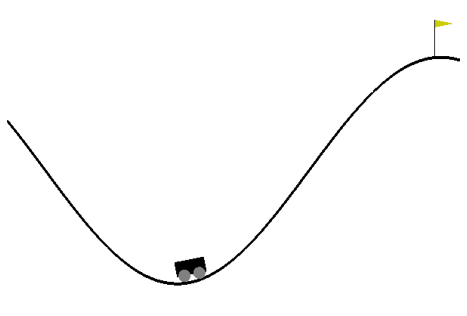

In [ ]:
#freate animation using the solution with least frames
frames=[]
for i in range(len(eps)):
  frames.append(len(eps[i]))
print (min(frames))
minIndex = frames.index(min(frames))
frames = eps[minIndex]
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

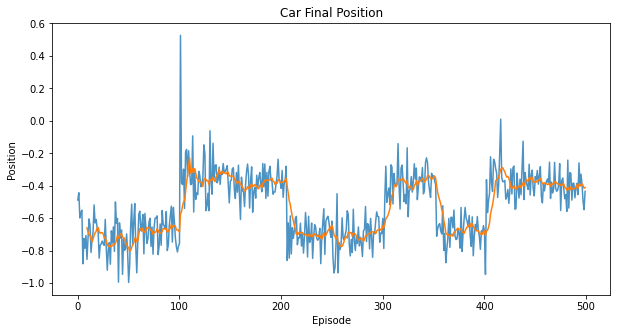

In [ ]:
#plot final position of cart after each episode
plt.figure(2, figsize=[10,5])
p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.savefig('Final Position - Modified.png')
plt.show()

In [ ]:
#plot color map for policy of agent
X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    _, temp = torch.max(policy(Variable(torch.from_numpy(np.array([X[i],Y[i]]))).type(torch.FloatTensor)), dim =-1)
    z = temp.item()
    Z.append(z)
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

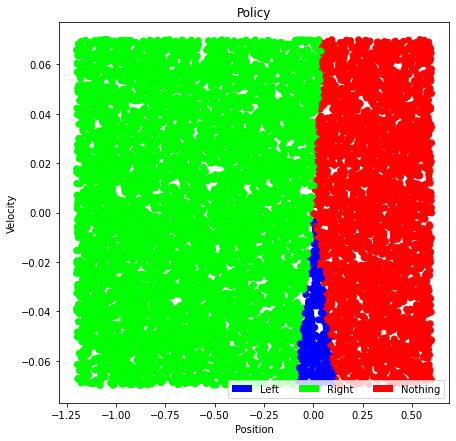

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
fig.savefig('Policy - Modified.png')
plt.show()